In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import numpy as np
import PIL.Image
import binvox_rw

In [2]:
tf.__version__

'1.3.0'

In [3]:
from lib.tfmodels import vgg16

vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [100]:
def gray_to_rgb(image):
    w, h = image.shape
    res = np.empty((w, h, 3), dtype=np.uint8)
    res[:, :, 0] = image
    res[:, :, 1] = image
    res[:, :, 2] = image
    return res

def color_from_2d(voxel, face, color):
    face_mask = np.where(face > -1)
    voxel[(face[face_mask],) + face_mask] = color[face_mask]

def voxel_to_2d(voxel):
    p1, p2, p3 = voxel, voxel.transpose((1,0,2)), voxel.transpose((2,1,0))
    p4, p5, p6 = np.flip(p1, axis=0), np.flip(p2, axis=0), np.flip(p3, axis=0)
    
    p = np.stack((p1, p2, p3, p4, p5, p6))
    faces = np.where(p.any(1), p.argmax(1), -1)
    faces_mask = np.where(faces > -1)
    
    colors = np.ones(faces.shape + (3,))
    vox_size = voxel.shape[0] 
    fzyx = (faces[faces_mask],) + (faces_mask[1:])
    colors[faces_mask] = np.stack(fzyx, axis=-1) / vox_size * 255.
    
    return faces, colors

def generate_voxel_colors(colors, faces, shape):
    voxel_colors = np.zeros(shape + (3,))
    views = [[0,1,2,3], [1,0,2,3], [2,0,1,3]]

    for i, v in enumerate(views):
        voxel_colors = voxel_colors.transpose(v)
        color_from_2d(voxel_colors, faces[i], colors[i])
        voxel_colors = np.flip(voxel_colors, axis=0)
        color_from_2d(voxel_colors, faces[i+3], colors[i+3])
        voxel_colors = np.flip(voxel_colors, axis=0)
    
    return voxel_colors.transpose((2,1,0,3))

def load_voxel(filename):
    with open(filename, 'rb') as f:
        model = binvox_rw.read_as_3d_array(f)
        
    return model.data

def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = np.asarray(image.resize(size, PIL.Image.LANCZOS), dtype=np.float32)

        if len(image.shape) == 2:
            image = gray_to_rgb(image)

    # Convert to numpy floating-point array.
    return np.asarray(image)

In [106]:
def color_from_2d(voxel, face, color):
#     face_mask = np.where(face > -1)
#     voxel[(face[face_mask],) + face_mask] = color[face_mask]
    
    coords_face = np.where(face[:,:,0])
    coords_vox = tuple(face[coords_face][:,1:].astype(int).T)
    print(voxel.shape, np.shape(coords_vox))
    print(np.shape(color[coords_face]))
    print(np.shape(voxel[coords_vox]))
    voxel[coords_vox] = color[coords_face]

# def voxel_to_2d(voxel):
#     p1, p2, p3 = voxel, voxel.transpose((1,0,2)), voxel.transpose((2,1,0))
#     p4, p5, p6 = np.flip(p1, axis=0), np.flip(p2, axis=0), np.flip(p3, axis=0)
    
#     p = np.stack((p1, p2, p3, p4, p5, p6))
#     faces = np.where(p.any(1), p.argmax(1), -1)
#     faces_mask = np.where(faces > -1)
    
#     colors = np.ones(faces.shape + (3,))
#     vox_size = voxel.shape[0] 
#     fzyx = (faces[faces_mask],) + (faces_mask[1:])
#     colors[faces_mask] = np.stack(fzyx, axis=-1) / vox_size
    
#     return faces, colors

def voxel_to_2d(voxel):
    tuple_voxels = np.zeros(voxel.shape + (4,))
    
    for x in range(voxel.shape[0]):
        for y in range(voxel.shape[1]):
            for z in range(voxel.shape[2]):
                tuple_voxels[x, y, z] = [voxel[x, y, z], x, y, z]
    print(tuple_voxels.shape)            
    p1, p2, p3 = tuple_voxels, tuple_voxels.transpose((1,0,2,3)), tuple_voxels.transpose((2,1,0, 3))
    p4, p5, p6 = np.flip(p1, axis=0), np.flip(p2, axis=0), np.flip(p3, axis=0)
    
    p = np.stack((p1, p2, p3, p4, p5, p6))
    print("p", p.shape) #6 * 32 * 32 * 32 * 4
    print("argmax", np.argmax(p[:,:,:,:,0], axis =1)[0].shape)
    argmax_vals = np.argmax(p[:,:,:,:,0], axis =1)
    faces_second = np.ones((p.shape[0],p.shape[2], p.shape[3], p.shape[4])) * -1
    print(argmax_vals.shape)
    
    for x in range(argmax_vals.shape[1]):
        for y in range(argmax_vals.shape[2]):
            for face in range(argmax_vals.shape[0]):
                faces_second[face,y,x] = p[face,argmax_vals[face,y, x], y, x]
            
    colors = np.ones((faces_second.shape[0], faces_second.shape[1],faces_second.shape[2])  + (3,)) * 255.        
    vox_size = voxel.shape[0]
    
    colors[:, :, :,0] =faces_second[:, :, :, 0]  * faces_second[:, :, :,2]/ vox_size * 255.
    colors[:, :, :,1] =faces_second[:, :, :, 0] * faces_second[:, :, :,2]/ vox_size * 255.
    colors[:, :, :,2] =faces_second[:, :, :, 0] * faces_second[:, :, :,3]/ vox_size *255.
    print(colors.shape)
    #print(colors)
    #print(faces_second.shape)
    #faces = np.where(p[:,:,:,:,0].any(1), np.argmax(p[:,:,:,:,0], axis = 1), [-1, 0, 0, 0]) # 6, 64, 64 - faces
    #faces_mask = np.where(faces_second[:,:,:,0] > -1)
    #print(faces_mask)
    #colors = np.ones(faces.shape + (3,)) * 255.
    #vox_size = voxel.shape[0] #get first dimension of 3d representation
    
    #fzyx = (np.zeros_like(faces[faces_mask]),) + (faces_mask[1:])
    # print(fzyx)
    #colors[faces_mask] = np.stack(fzyx, axis=-1) / vox_size * 255.
    
    #voxel_pos = np.stack(np.where(voxel), axis=-1)
    
    return faces_second, colors

def generate_voxel_colors(colors, faces, shape):
    voxel_colors = np.zeros(shape + (3,))
#     views = [[0,1,2,3], [1,0,2,3], [2,0,1,3]]
    
#     for i, v in enumerate(views):
#         voxel_colors = voxel_colors.transpose(v)
#         color_from_2d(voxel_colors, faces[i], colors[i])
#         voxel_colors = np.flip(voxel_colors, axis=0)
#         color_from_2d(voxel_colors, faces[i+3], colors[i+3])
#         voxel_colors = np.flip(voxel_colors, axis=0)
    
    for i in range(len(faces)):
        color_from_2d(voxel_colors, faces[i], colors[i])
#     return voxel_colors.transpose((2,1,0,3))
    return voxel_colors

In [5]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [6]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [60]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = False
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_2d_faces(face_colors):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, face in enumerate(face_colors):
        ax = axes.flat[i]
        ax.imshow(face / 255.0)

    plt.show()
    
def plot_3d_voxel(voxel, colors):
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel, facecolors=colors / 255.0)

    plt.show()

In [8]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [9]:
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)
            
        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [10]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram

In [11]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
        
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [12]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [13]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)
    
    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)
    
    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

In [113]:
voxel_filename = '3Dmodels/model.binvox'
voxel = load_voxel(voxel_filename)
face_maps, face_colors = voxel_to_2d(voxel)

(128, 128, 128, 4)
p (6, 128, 128, 128, 4)
argmax (128, 128)
(6, 128, 128)
(6, 128, 128, 3)


In [73]:
content_layer_ids = [4]

In [89]:
style_filename = 'images/snake_style.jpg'
style_image = load_image(style_filename, max_size=voxel.shape[0])

In [76]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = np.arange(13)

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 4.63e-11, Style: 4.47e-27, Denoise: 3.08e-05


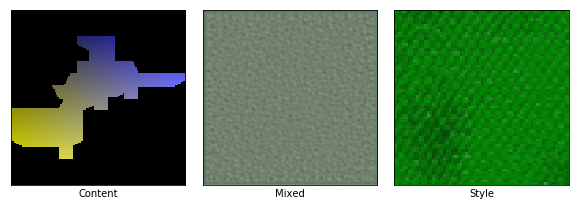

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 6.20e-11, Style: 2.85e-26, Denoise: 1.59e-06


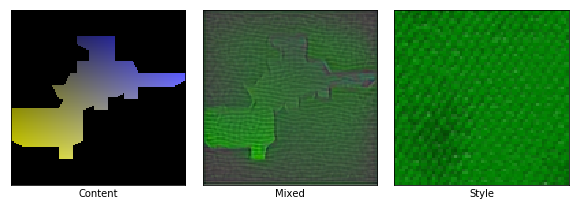

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 6.86e-11, Style: 9.74e-26, Denoise: 3.25e-06


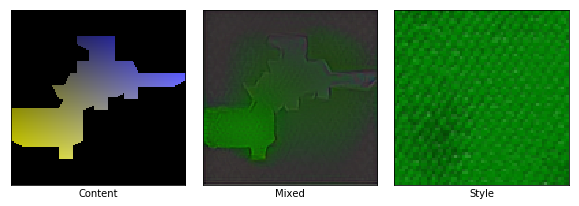

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 7.72e-11, Style: 2.80e-25, Denoise: 3.25e-06


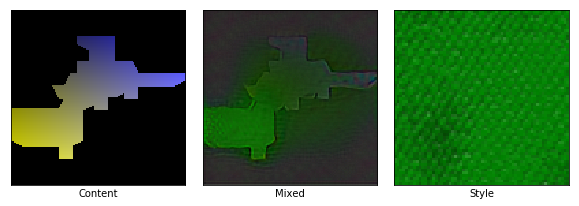

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 8.29e-11, Style: 3.07e-25, Denoise: 3.66e-06


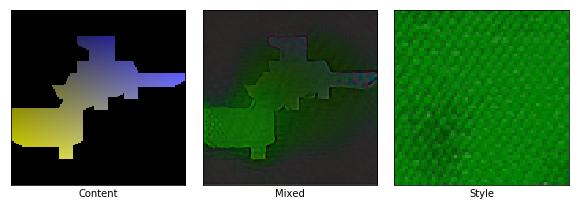

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 8.52e-11, Style: 3.09e-25, Denoise: 3.80e-06


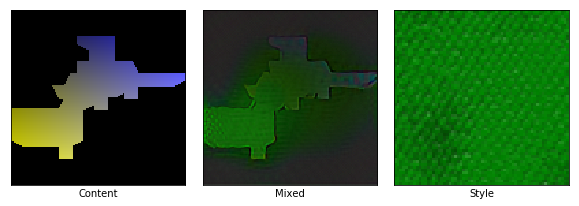

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 8.23e-11, Style: 4.55e-26, Denoise: 4.23e-06


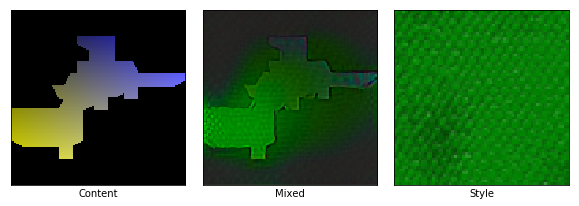


Final image:


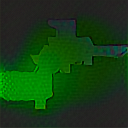

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 6.95e-11, Style: 4.47e-27, Denoise: 3.07e-05


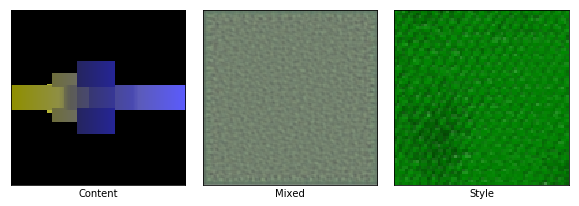

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 9.21e-11, Style: 2.66e-26, Denoise: 1.57e-06


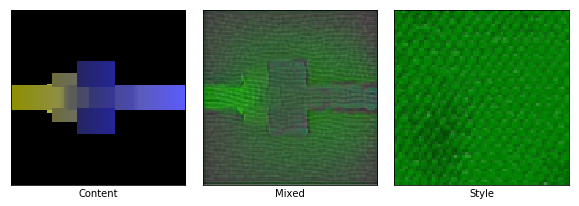

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 8.92e-11, Style: 9.02e-26, Denoise: 2.12e-06


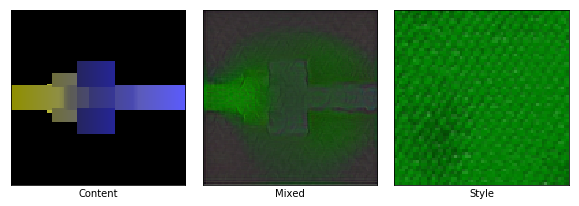

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 1.21e-10, Style: 2.34e-25, Denoise: 3.38e-06


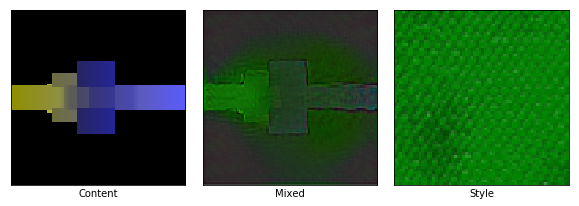

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 1.28e-10, Style: 2.64e-25, Denoise: 3.60e-06


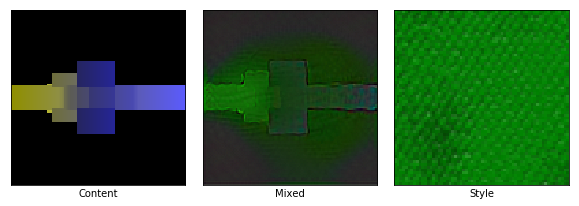

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 1.33e-10, Style: 2.72e-25, Denoise: 3.72e-06


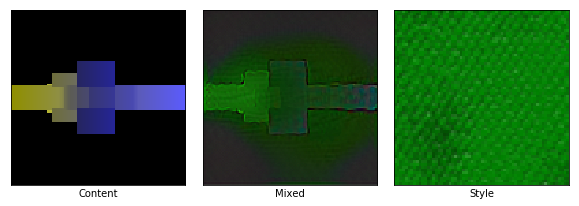

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 1.34e-10, Style: 4.71e-26, Denoise: 4.30e-06


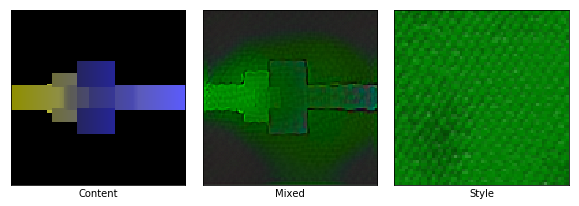


Final image:


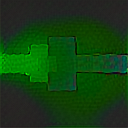

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 6.42e-11, Style: 4.47e-27, Denoise: 3.08e-05


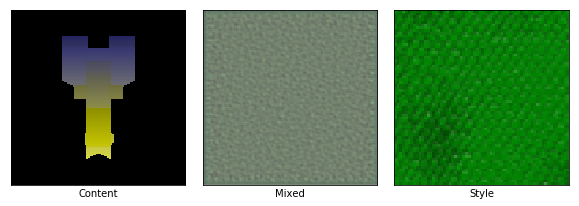

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 1.03e-10, Style: 3.01e-26, Denoise: 1.60e-06


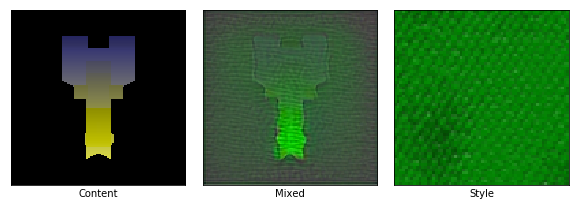

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 1.17e-10, Style: 9.58e-26, Denoise: 3.41e-06


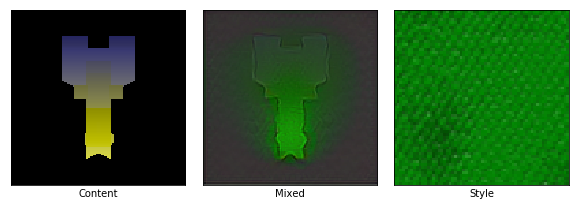

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 1.34e-10, Style: 2.11e-25, Denoise: 3.57e-06


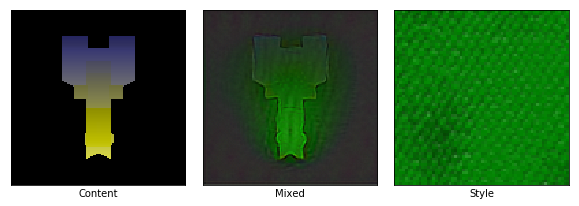

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 1.45e-10, Style: 2.19e-25, Denoise: 4.07e-06


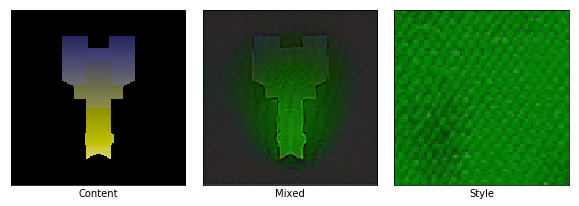

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 1.52e-10, Style: 2.28e-25, Denoise: 4.20e-06


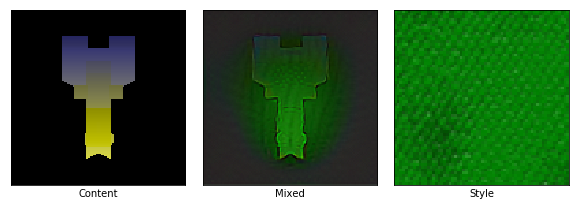

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 1.47e-10, Style: 4.63e-26, Denoise: 4.66e-06


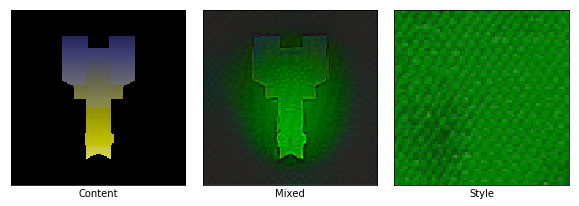


Final image:


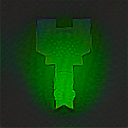

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 4.63e-11, Style: 4.47e-27, Denoise: 3.08e-05


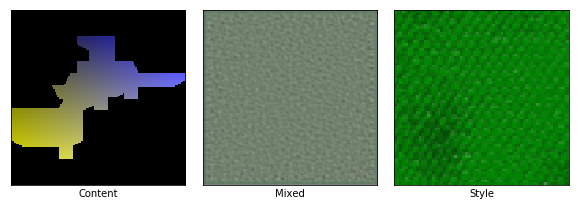

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 6.31e-11, Style: 2.83e-26, Denoise: 1.60e-06


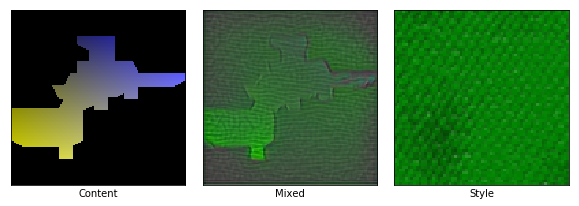

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 6.38e-11, Style: 8.34e-26, Denoise: 3.12e-06


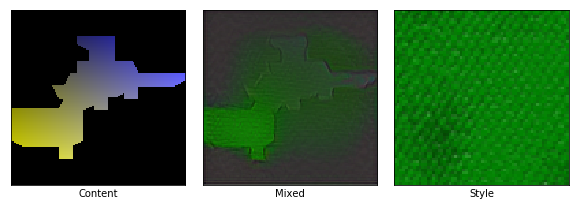

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 7.99e-11, Style: 2.57e-25, Denoise: 3.60e-06


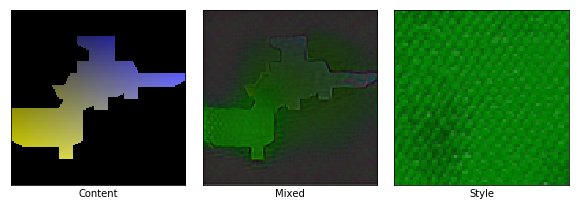

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 8.24e-11, Style: 2.99e-25, Denoise: 3.63e-06


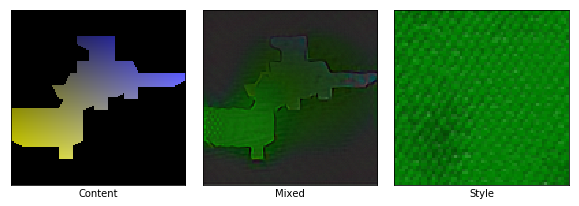

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 8.55e-11, Style: 3.02e-25, Denoise: 3.83e-06


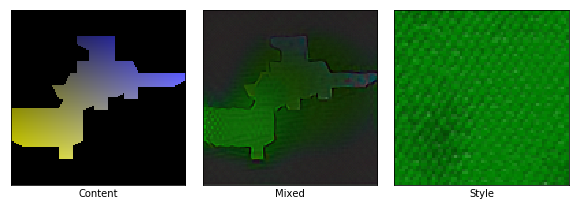

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 8.19e-11, Style: 4.55e-26, Denoise: 4.20e-06


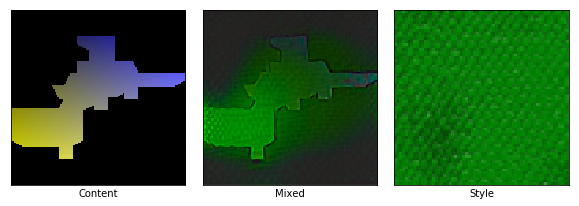


Final image:


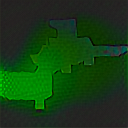

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 5.61e-11, Style: 4.47e-27, Denoise: 3.07e-05


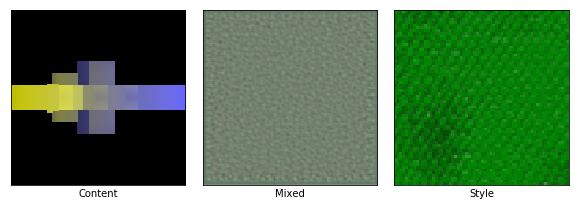

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 7.34e-11, Style: 2.87e-26, Denoise: 1.60e-06


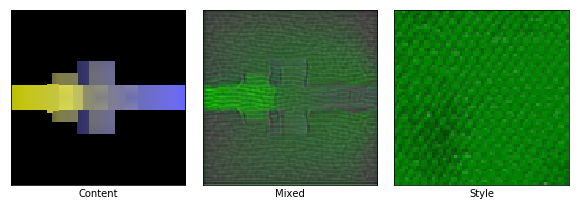

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 7.52e-11, Style: 8.48e-26, Denoise: 2.80e-06


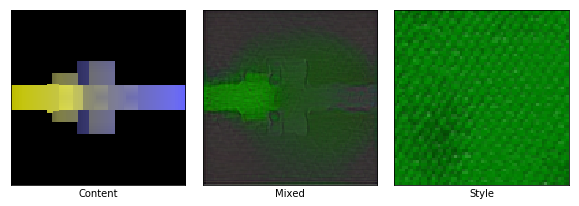

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 9.55e-11, Style: 2.43e-25, Denoise: 3.44e-06


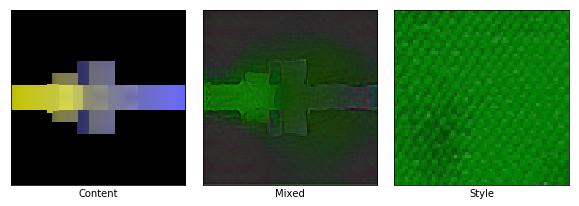

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 9.84e-11, Style: 2.79e-25, Denoise: 3.71e-06


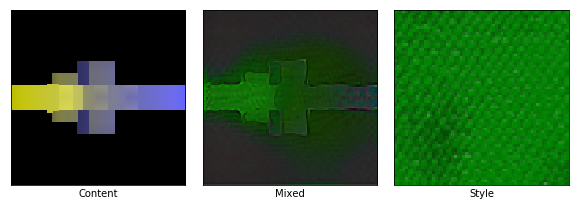

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 1.00e-10, Style: 2.83e-25, Denoise: 3.80e-06


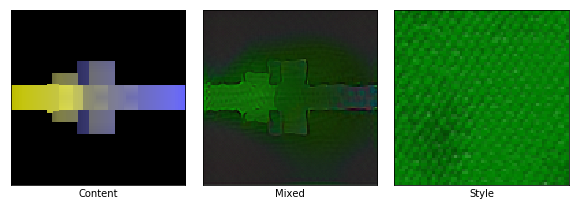

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 9.64e-11, Style: 4.61e-26, Denoise: 4.32e-06


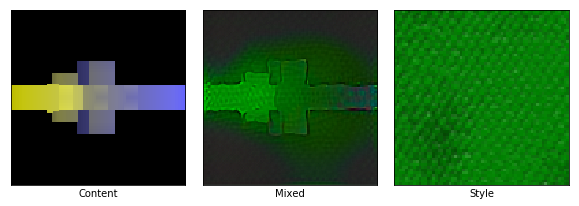


Final image:


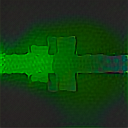

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 5.65e-11, Style: 4.47e-27, Denoise: 3.05e-05


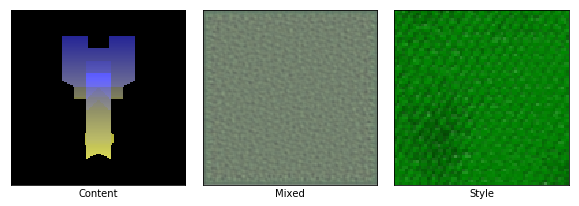

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 8.28e-11, Style: 2.78e-26, Denoise: 1.56e-06


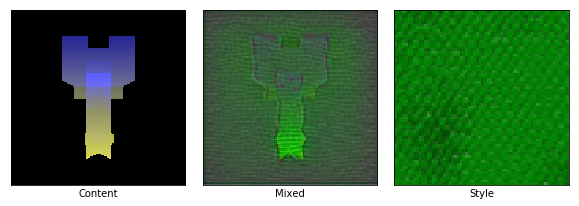

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 8.43e-11, Style: 8.10e-26, Denoise: 3.13e-06


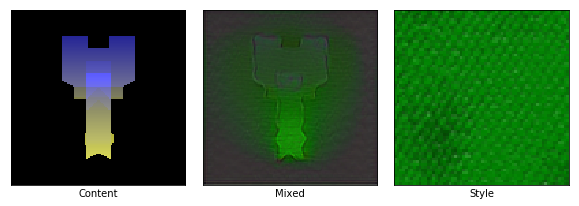

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 1.08e-10, Style: 2.50e-25, Denoise: 3.58e-06


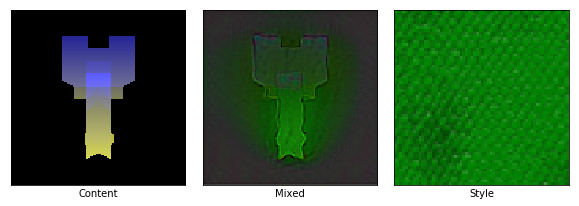

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 1.10e-10, Style: 2.69e-25, Denoise: 3.70e-06


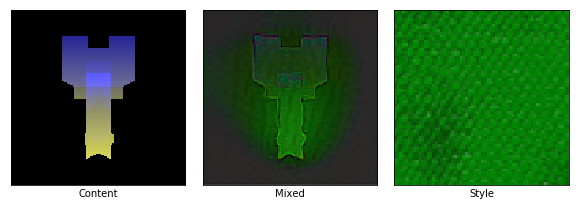

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 1.15e-10, Style: 2.69e-25, Denoise: 3.87e-06


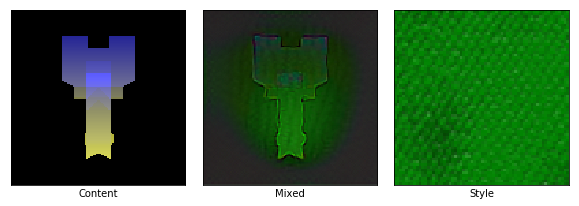

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 1.13e-10, Style: 4.53e-26, Denoise: 4.35e-06


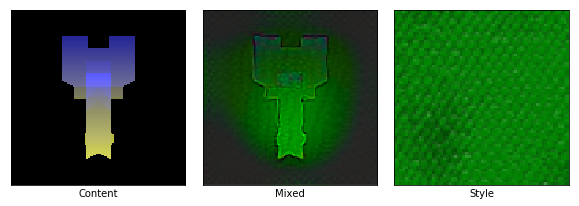


Final image:


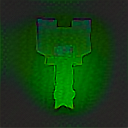

(128, 128, 128, 3) (3, 3965)
(3965, 3)
(3965, 3)
(128, 128, 128, 3) (3, 3648)
(3648, 3)
(3648, 3)
(128, 128, 128, 3) (3, 2914)
(2914, 3)
(2914, 3)
(128, 128, 128, 3) (3, 3965)
(3965, 3)
(3965, 3)
(128, 128, 128, 3) (3, 3648)
(3648, 3)
(3648, 3)
(128, 128, 128, 3) (3, 2914)
(2914, 3)
(2914, 3)


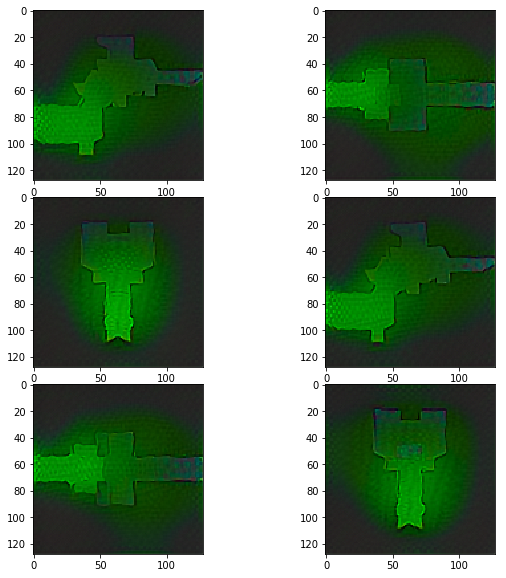

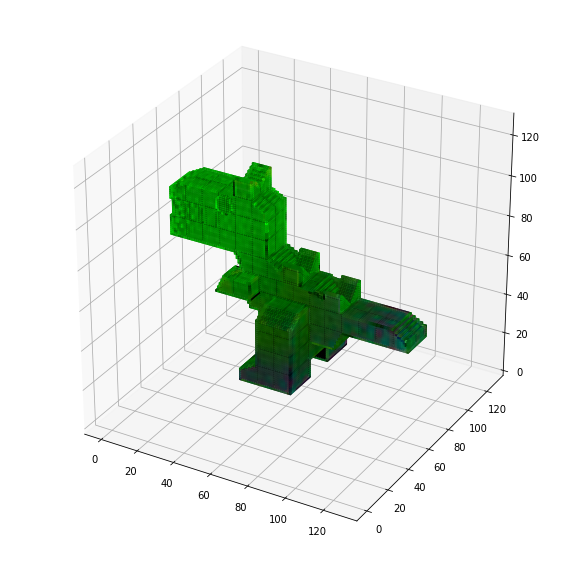

CPU times: user 20min 9s, sys: 2min 13s, total: 22min 22s
Wall time: 10min 22s


In [114]:
%%time
for i in range(len(face_colors)):
    face_colors[i] = style_transfer(content_image=face_colors[i],
                             style_image=style_image,
                             content_layer_ids=content_layer_ids,
                             style_layer_ids=style_layer_ids,
                             weight_content=1.5,
                             weight_style=10.0,
                             weight_denoise=0.3,
                             num_iterations=60,
                             step_size=10.0)
    
colors = generate_voxel_colors(face_colors, face_maps, voxel.shape)

plot_2d_faces(face_colors)

plot_3d_voxel(voxel.transpose((2,0,1)), colors.transpose((2,0,1,3)))